# EuroSAT Dataset Applying Pre-trained CNN VGG16

In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
import platform
import psutil
import random
import cv2
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
from PIL import ImageOps

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.models as models

from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur

from tqdm.notebook import tqdm
from tqdm import tqdm

from torchinfo import summary
from torchsummary import summary

from collections import OrderedDict

from tabulate import tabulate

### Configuration

In [2]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


### Seed Value

In [3]:
seed = 5
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Loading Dataset

In [4]:
data_dir = "/kaggle/input/eurosat-dataset/EuroSAT"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
     if not class_name.lower().endswith(('.csv', '.json')):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame(
    {
        "file_path": file_paths,
        "label": labels,
        }
    )
df = df.sample(frac=1).reset_index(drop=True)

### Class Count & Bar Plot

class: HerbaceousVegetation --> count: 3000
class: AnnualCrop --> count: 3000
class: Forest --> count: 3000
class: SeaLake --> count: 3000
class: Residential --> count: 3000
class: PermanentCrop --> count: 2500
class: Industrial --> count: 2500
class: River --> count: 2500
class: Highway --> count: 2500
class: Pasture --> count: 2000


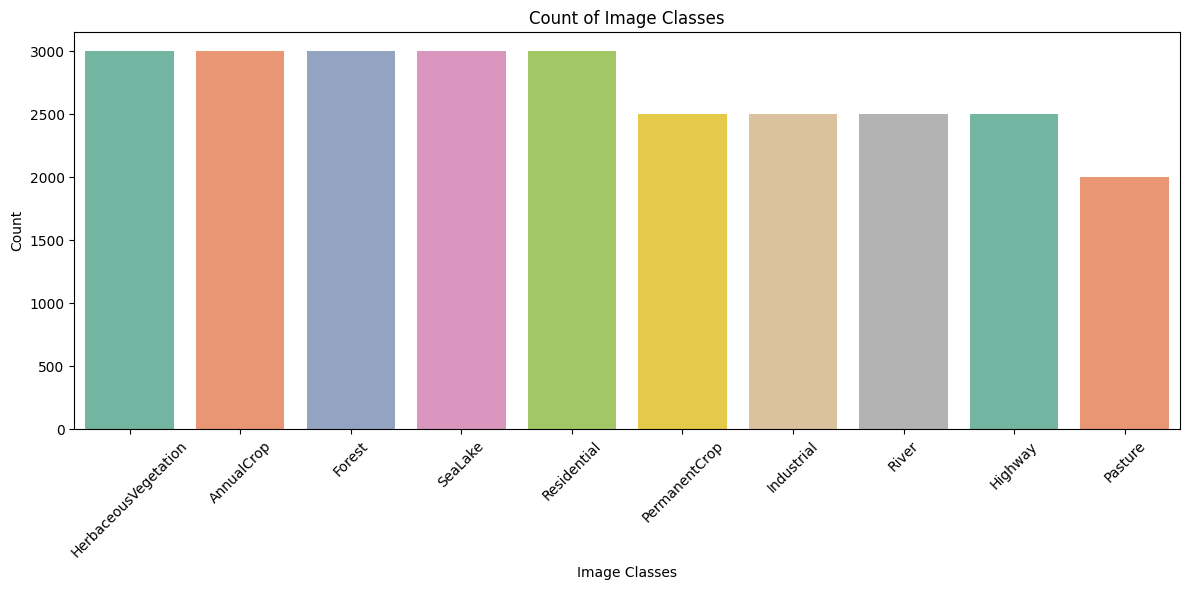

In [5]:
# Class count and Bar plot
class_count = df['label'].value_counts()

for class_name , count in class_count.items():
    print(f"class: {class_name} --> count: {count}")

# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index, palette='Set2')
plt.title('Count of Image Classes')
plt.xlabel('Image Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Sample Images From Each Classes

In [ ]:
# Get class names
class_names = sorted(df['label'].unique())

# set up figure
plt.figure(figsize=(3 * 2.5, len(class_names) / 3  * 2.5))

# One sample image per class
for i, class_name in enumerate(class_names):
    try:
        # get sample for this class
        path = df[df['label'] == class_name]['file_path'].sample(1).values[0]
        with Image.open(path) as img:
            plt.subplot(int(len(class_names) / 3)+1, 3, i+1)
            plt.imshow(img)
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        continue


plt.tight_layout()
plt.show()

### Train-Test-Validation Split (Ratio 70:15:15)

In [ ]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30,
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50,
                                            stratify=temp_dataframe['label'], random_state=42)

In [ ]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18900
Validation Data:  4050
Test Data:  4050
-------------------------------------------
Total amounts of data in the dataset:  27000


In [ ]:

class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                   Count
--------------------  -------
Residential              2100
SeaLake                  2100
AnnualCrop               2100
Forest                   2100
HerbaceousVegetation     2100
PermanentCrop            1750
Industrial               1750
Highway                  1750
River                    1750
Pasture                  1400

Validation Dataset
Class                   Count
--------------------  -------
AnnualCrop                450
SeaLake                   450
Residential               450
HerbaceousVegetation      450
Forest                    450
Highway                   375
Industrial                375
PermanentCrop             375
River                     375
Pasture                   300

Test Dataset
Class                   Count
--------------------  -------
SeaLake                   450
AnnualCrop                450
Forest                    450
HerbaceousVegetation      450
Residential               450
PermanentCrop         

### Lable mapping

In [ ]:
classes = sorted(df['label'].unique())
label_map = {class_name: i for i, class_name in enumerate(classes)}
print(label_map)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Device Variable

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Checkpoint

In [ ]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Integrate Class-weight Loss

In [13]:
# Extract class labels from your training dataframe
train_labels = train_dataframe['label'].map(label_map).values
num_classes = len(classes)

# print(np.unique(train_labels))
# print(np.arange(num_classes))

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(num_classes), y=train_labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

### Dataset Class, Dataloader and Transform

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.classes = sorted(dataframe['label'].unique())
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)



In [15]:
train_batch = 64
val_batch = 8

def data_transfrom():
    size = 224
    normalize = transforms.Compose([
            transforms.Resize((size,size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])

    train_transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
        transforms.ToTensor(),
    ])
    
    train_dataset = ImageDataset (
        train_dataframe,
        train_transform,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=4)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=4)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=4)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

### Neural Network (ResNet)

In [16]:
total_class = 10
learning_rate = 0.0001

model = models.vgg16(pretrained=False)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier[6] = nn.Linear(4096, total_class)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Training

In [17]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=150, early_stop_patience=150, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"✅ Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"⏹️ Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model,
    criterion,
    optimizer,
    dataloader_train_dataset,
    dataloader_valid_dataset,
    save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/150: 100%|██████████| 296/296 [01:24<00:00,  3.51it/s, acc=0.268, loss=1.87]

Training Loss: 1.873 Acc: 0.268


Validation Loss: 1.546 Acc: 0.387
✅ Best model saved at epoch 1 with validation accuracy: 0.387


Epoch 2/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.405, loss=1.52]

Training Loss: 1.524 Acc: 0.405


Validation Loss: 1.345 Acc: 0.486
✅ Best model saved at epoch 2 with validation accuracy: 0.486


Epoch 3/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.473, loss=1.37]

Training Loss: 1.371 Acc: 0.473


Validation Loss: 1.312 Acc: 0.503
✅ Best model saved at epoch 3 with validation accuracy: 0.503


Epoch 4/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.529, loss=1.25]

Training Loss: 1.251 Acc: 0.529


Validation Loss: 1.107 Acc: 0.579
✅ Best model saved at epoch 4 with validation accuracy: 0.579


Epoch 5/150: 100%|██████████| 296/296 [00:59<00:00,  5.02it/s, acc=0.566, loss=1.18]

Training Loss: 1.184 Acc: 0.566


Validation Loss: 1.055 Acc: 0.631
✅ Best model saved at epoch 5 with validation accuracy: 0.631


Epoch 6/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.594, loss=1.12]

Training Loss: 1.120 Acc: 0.594


Validation Loss: 1.020 Acc: 0.625


Epoch 7/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.607, loss=1.09]

Training Loss: 1.090 Acc: 0.607


Validation Loss: 0.931 Acc: 0.671
✅ Best model saved at epoch 7 with validation accuracy: 0.671


Epoch 8/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.62, loss=1.06] 

Training Loss: 1.057 Acc: 0.620


Validation Loss: 0.960 Acc: 0.643


Epoch 9/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.624, loss=1.04]

Training Loss: 1.040 Acc: 0.624


Validation Loss: 0.913 Acc: 0.659


Epoch 10/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.635, loss=1.02]

Training Loss: 1.017 Acc: 0.635


Validation Loss: 0.982 Acc: 0.658


Epoch 11/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.642, loss=1]   

Training Loss: 1.005 Acc: 0.642


Validation Loss: 0.851 Acc: 0.687
✅ Best model saved at epoch 11 with validation accuracy: 0.687


Epoch 12/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.648, loss=0.982]

Training Loss: 0.982 Acc: 0.648


Validation Loss: 0.854 Acc: 0.692
✅ Best model saved at epoch 12 with validation accuracy: 0.692


Epoch 13/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.652, loss=0.974]

Training Loss: 0.974 Acc: 0.652


Validation Loss: 0.829 Acc: 0.697
✅ Best model saved at epoch 13 with validation accuracy: 0.697


Epoch 14/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.653, loss=0.969]

Training Loss: 0.969 Acc: 0.653


Validation Loss: 0.863 Acc: 0.681


Epoch 15/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.658, loss=0.961]

Training Loss: 0.961 Acc: 0.658


Validation Loss: 0.826 Acc: 0.710
✅ Best model saved at epoch 15 with validation accuracy: 0.710


Epoch 16/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.664, loss=0.943]

Training Loss: 0.943 Acc: 0.664


Validation Loss: 0.806 Acc: 0.717
✅ Best model saved at epoch 16 with validation accuracy: 0.717


Epoch 17/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.667, loss=0.935]

Training Loss: 0.935 Acc: 0.667


Validation Loss: 0.846 Acc: 0.688


Epoch 18/150: 100%|██████████| 296/296 [00:58<00:00,  5.07it/s, acc=0.669, loss=0.932]

Training Loss: 0.932 Acc: 0.669


Validation Loss: 0.796 Acc: 0.722
✅ Best model saved at epoch 18 with validation accuracy: 0.722


Epoch 19/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.666, loss=0.935]

Training Loss: 0.935 Acc: 0.666


Validation Loss: 0.828 Acc: 0.707


Epoch 20/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.672, loss=0.925]

Training Loss: 0.925 Acc: 0.672


Validation Loss: 0.838 Acc: 0.706


Epoch 21/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.671, loss=0.909]

Training Loss: 0.909 Acc: 0.671


Validation Loss: 0.765 Acc: 0.721


Epoch 22/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.679, loss=0.904]

Training Loss: 0.904 Acc: 0.679


Validation Loss: 0.776 Acc: 0.714


Epoch 23/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.681, loss=0.896]

Training Loss: 0.896 Acc: 0.681


Validation Loss: 0.768 Acc: 0.721


Epoch 24/150: 100%|██████████| 296/296 [00:58<00:00,  5.07it/s, acc=0.68, loss=0.892] 

Training Loss: 0.892 Acc: 0.680


Validation Loss: 0.779 Acc: 0.720


Epoch 25/150: 100%|██████████| 296/296 [00:58<00:00,  5.07it/s, acc=0.682, loss=0.889]

Training Loss: 0.889 Acc: 0.682


Validation Loss: 0.767 Acc: 0.725
✅ Best model saved at epoch 25 with validation accuracy: 0.725


Epoch 26/150: 100%|██████████| 296/296 [00:58<00:00,  5.07it/s, acc=0.684, loss=0.888]

Training Loss: 0.888 Acc: 0.684


Validation Loss: 0.759 Acc: 0.723


Epoch 27/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.685, loss=0.882]

Training Loss: 0.882 Acc: 0.685


Validation Loss: 0.742 Acc: 0.723


Epoch 28/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.684, loss=0.879]

Training Loss: 0.879 Acc: 0.684


Validation Loss: 0.748 Acc: 0.734
✅ Best model saved at epoch 28 with validation accuracy: 0.734


Epoch 29/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.692, loss=0.865]

Training Loss: 0.865 Acc: 0.692


Validation Loss: 0.736 Acc: 0.732


Epoch 30/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.688, loss=0.865]

Training Loss: 0.865 Acc: 0.688


Validation Loss: 0.769 Acc: 0.718


Epoch 31/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.687, loss=0.873]

Training Loss: 0.873 Acc: 0.687


Validation Loss: 0.743 Acc: 0.722


Epoch 32/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.687, loss=0.878]

Training Loss: 0.878 Acc: 0.687


Validation Loss: 0.755 Acc: 0.724


Epoch 33/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.692, loss=0.856]

Training Loss: 0.856 Acc: 0.692


Validation Loss: 0.734 Acc: 0.727


Epoch 34/150: 100%|██████████| 296/296 [00:58<00:00,  5.07it/s, acc=0.694, loss=0.859]

Training Loss: 0.859 Acc: 0.694


Validation Loss: 0.726 Acc: 0.742
✅ Best model saved at epoch 34 with validation accuracy: 0.742


Epoch 35/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.696, loss=0.852]

Training Loss: 0.852 Acc: 0.696


Validation Loss: 0.782 Acc: 0.722


Epoch 36/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.695, loss=0.854]

Training Loss: 0.854 Acc: 0.695


Validation Loss: 0.716 Acc: 0.743
✅ Best model saved at epoch 36 with validation accuracy: 0.743


Epoch 37/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.701, loss=0.835]

Training Loss: 0.835 Acc: 0.701


Validation Loss: 0.703 Acc: 0.736


Epoch 38/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.696, loss=0.843]

Training Loss: 0.843 Acc: 0.696


Validation Loss: 0.739 Acc: 0.729


Epoch 39/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.696, loss=0.845]

Training Loss: 0.845 Acc: 0.696


Validation Loss: 0.714 Acc: 0.735


Epoch 40/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.704, loss=0.83] 

Training Loss: 0.830 Acc: 0.704


Validation Loss: 0.742 Acc: 0.723


Epoch 41/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.703, loss=0.827]

Training Loss: 0.827 Acc: 0.703


Validation Loss: 0.683 Acc: 0.754
✅ Best model saved at epoch 41 with validation accuracy: 0.754


Epoch 42/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.703, loss=0.836]

Training Loss: 0.836 Acc: 0.703


Validation Loss: 0.717 Acc: 0.740


Epoch 43/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.704, loss=0.823]

Training Loss: 0.823 Acc: 0.704


Validation Loss: 0.706 Acc: 0.747


Epoch 44/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.705, loss=0.821]

Training Loss: 0.821 Acc: 0.705


Validation Loss: 0.675 Acc: 0.755
✅ Best model saved at epoch 44 with validation accuracy: 0.755


Epoch 45/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.706, loss=0.823]

Training Loss: 0.823 Acc: 0.706


Validation Loss: 0.699 Acc: 0.750


Epoch 46/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.709, loss=0.811]

Training Loss: 0.811 Acc: 0.709


Validation Loss: 0.678 Acc: 0.754


Epoch 47/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.705, loss=0.813]

Training Loss: 0.813 Acc: 0.705


Validation Loss: 0.667 Acc: 0.755


Epoch 48/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.712, loss=0.812]

Training Loss: 0.812 Acc: 0.712


Validation Loss: 0.669 Acc: 0.763
✅ Best model saved at epoch 48 with validation accuracy: 0.763


Epoch 49/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.711, loss=0.806]

Training Loss: 0.806 Acc: 0.711


Validation Loss: 0.716 Acc: 0.747


Epoch 50/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.711, loss=0.808]

Training Loss: 0.808 Acc: 0.711


Validation Loss: 0.670 Acc: 0.765
✅ Best model saved at epoch 50 with validation accuracy: 0.765


Epoch 51/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.711, loss=0.804]

Training Loss: 0.804 Acc: 0.711


Validation Loss: 0.681 Acc: 0.747


Epoch 52/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.709, loss=0.804]

Training Loss: 0.804 Acc: 0.709


Validation Loss: 0.680 Acc: 0.757


Epoch 53/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.712, loss=0.802]

Training Loss: 0.802 Acc: 0.712


Validation Loss: 0.669 Acc: 0.758


Epoch 54/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.715, loss=0.798]

Training Loss: 0.798 Acc: 0.715


Validation Loss: 0.665 Acc: 0.760


Epoch 55/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.712, loss=0.806]

Training Loss: 0.806 Acc: 0.712


Validation Loss: 0.665 Acc: 0.764


Epoch 56/150: 100%|██████████| 296/296 [00:59<00:00,  5.02it/s, acc=0.716, loss=0.792]

Training Loss: 0.792 Acc: 0.716


Validation Loss: 0.649 Acc: 0.765


Epoch 57/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.716, loss=0.791]

Training Loss: 0.791 Acc: 0.716


Validation Loss: 0.651 Acc: 0.771
✅ Best model saved at epoch 57 with validation accuracy: 0.771


Epoch 58/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.715, loss=0.791]

Training Loss: 0.791 Acc: 0.715


Validation Loss: 0.656 Acc: 0.760


Epoch 59/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.713, loss=0.793]

Training Loss: 0.793 Acc: 0.713


Validation Loss: 0.649 Acc: 0.766


Epoch 60/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.716, loss=0.788]

Training Loss: 0.788 Acc: 0.716


Validation Loss: 0.642 Acc: 0.766


Epoch 61/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.719, loss=0.787]

Training Loss: 0.787 Acc: 0.719


Validation Loss: 0.638 Acc: 0.773
✅ Best model saved at epoch 61 with validation accuracy: 0.773


Epoch 62/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.722, loss=0.783]

Training Loss: 0.783 Acc: 0.722


Validation Loss: 0.665 Acc: 0.757


Epoch 63/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.716, loss=0.783]

Training Loss: 0.783 Acc: 0.716


Validation Loss: 0.663 Acc: 0.762


Epoch 64/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.72, loss=0.778] 

Training Loss: 0.778 Acc: 0.720


Validation Loss: 0.658 Acc: 0.757


Epoch 65/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.719, loss=0.776]

Training Loss: 0.776 Acc: 0.719


Validation Loss: 0.655 Acc: 0.760


Epoch 66/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.719, loss=0.779]

Training Loss: 0.779 Acc: 0.719


Validation Loss: 0.647 Acc: 0.769


Epoch 67/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.719, loss=0.777]

Training Loss: 0.777 Acc: 0.719


Validation Loss: 0.639 Acc: 0.769


Epoch 68/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.724, loss=0.773]

Training Loss: 0.773 Acc: 0.724


Validation Loss: 0.646 Acc: 0.772


Epoch 69/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.722, loss=0.776]

Training Loss: 0.776 Acc: 0.722


Validation Loss: 0.652 Acc: 0.774
✅ Best model saved at epoch 69 with validation accuracy: 0.774


Epoch 70/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.726, loss=0.764]

Training Loss: 0.764 Acc: 0.726


Validation Loss: 0.642 Acc: 0.763


Epoch 71/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.719, loss=0.776]

Training Loss: 0.776 Acc: 0.719


Validation Loss: 0.663 Acc: 0.755


Epoch 72/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.723, loss=0.772]

Training Loss: 0.772 Acc: 0.723


Validation Loss: 0.631 Acc: 0.775
✅ Best model saved at epoch 72 with validation accuracy: 0.775


Epoch 73/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.721, loss=0.771]

Training Loss: 0.771 Acc: 0.721


Validation Loss: 0.627 Acc: 0.773


Epoch 74/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.724, loss=0.761]

Training Loss: 0.761 Acc: 0.724


Validation Loss: 0.663 Acc: 0.766


Epoch 75/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.728, loss=0.764]

Training Loss: 0.764 Acc: 0.728


Validation Loss: 0.659 Acc: 0.766


Epoch 76/150: 100%|██████████| 296/296 [01:00<00:00,  4.92it/s, acc=0.726, loss=0.763]

Training Loss: 0.763 Acc: 0.726


Validation Loss: 0.635 Acc: 0.766


Epoch 77/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.729, loss=0.752]

Training Loss: 0.752 Acc: 0.729


Validation Loss: 0.622 Acc: 0.779
✅ Best model saved at epoch 77 with validation accuracy: 0.779


Epoch 78/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.724, loss=0.76] 

Training Loss: 0.760 Acc: 0.724


Validation Loss: 0.612 Acc: 0.786
✅ Best model saved at epoch 78 with validation accuracy: 0.786


Epoch 79/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.729, loss=0.761]

Training Loss: 0.761 Acc: 0.729


Validation Loss: 0.626 Acc: 0.772


Epoch 80/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.733, loss=0.75] 

Training Loss: 0.750 Acc: 0.733


Validation Loss: 0.638 Acc: 0.763


Epoch 81/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.726, loss=0.76] 

Training Loss: 0.760 Acc: 0.726


Validation Loss: 0.629 Acc: 0.777


Epoch 82/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.728, loss=0.749]

Training Loss: 0.749 Acc: 0.728


Validation Loss: 0.641 Acc: 0.770


Epoch 83/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.731, loss=0.756]

Training Loss: 0.756 Acc: 0.731


Validation Loss: 0.666 Acc: 0.754


Epoch 84/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.729, loss=0.753]

Training Loss: 0.753 Acc: 0.729


Validation Loss: 0.649 Acc: 0.766


Epoch 85/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.731, loss=0.751]

Training Loss: 0.751 Acc: 0.731


Validation Loss: 0.625 Acc: 0.769


Epoch 86/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.734, loss=0.752]

Training Loss: 0.752 Acc: 0.734


Validation Loss: 0.625 Acc: 0.782


Epoch 87/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.735, loss=0.746]

Training Loss: 0.746 Acc: 0.735


Validation Loss: 0.648 Acc: 0.768


Epoch 88/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.731, loss=0.75] 

Training Loss: 0.750 Acc: 0.731


Validation Loss: 0.624 Acc: 0.770


Epoch 89/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.73, loss=0.753] 

Training Loss: 0.753 Acc: 0.730


Validation Loss: 0.606 Acc: 0.787
✅ Best model saved at epoch 89 with validation accuracy: 0.787


Epoch 90/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.732, loss=0.748]

Training Loss: 0.748 Acc: 0.732


Validation Loss: 0.657 Acc: 0.767


Epoch 91/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.733, loss=0.746]

Training Loss: 0.746 Acc: 0.733


Validation Loss: 0.621 Acc: 0.777


Epoch 92/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.732, loss=0.743]

Training Loss: 0.743 Acc: 0.732


Validation Loss: 0.647 Acc: 0.766


Epoch 93/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.736, loss=0.747]

Training Loss: 0.747 Acc: 0.736


Validation Loss: 0.613 Acc: 0.781


Epoch 94/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.733, loss=0.745]

Training Loss: 0.745 Acc: 0.733


Validation Loss: 0.627 Acc: 0.770


Epoch 95/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.73, loss=0.744] 

Training Loss: 0.744 Acc: 0.730


Validation Loss: 0.612 Acc: 0.780


Epoch 96/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.734, loss=0.741]

Training Loss: 0.741 Acc: 0.734


Validation Loss: 0.623 Acc: 0.775


Epoch 97/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.733, loss=0.741]

Training Loss: 0.741 Acc: 0.733


Validation Loss: 0.617 Acc: 0.782


Epoch 98/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.736, loss=0.741]

Training Loss: 0.741 Acc: 0.736


Validation Loss: 0.613 Acc: 0.782


Epoch 99/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.736, loss=0.74] 

Training Loss: 0.740 Acc: 0.736


Validation Loss: 0.608 Acc: 0.785


Epoch 100/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.736, loss=0.735]

Training Loss: 0.735 Acc: 0.736


Validation Loss: 0.612 Acc: 0.777


Epoch 101/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.74, loss=0.731] 

Training Loss: 0.731 Acc: 0.740


Validation Loss: 0.634 Acc: 0.773


Epoch 102/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.735, loss=0.732]

Training Loss: 0.732 Acc: 0.735


Validation Loss: 0.618 Acc: 0.782


Epoch 103/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.74, loss=0.725] 

Training Loss: 0.725 Acc: 0.740


Validation Loss: 0.596 Acc: 0.786


Epoch 104/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.739, loss=0.734]

Training Loss: 0.734 Acc: 0.739


Validation Loss: 0.631 Acc: 0.776


Epoch 105/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.734, loss=0.739]

Training Loss: 0.739 Acc: 0.734


Validation Loss: 0.639 Acc: 0.768


Epoch 106/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.733, loss=0.728]

Training Loss: 0.728 Acc: 0.733


Validation Loss: 0.594 Acc: 0.784


Epoch 107/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.733, loss=0.732]

Training Loss: 0.732 Acc: 0.733


Validation Loss: 0.598 Acc: 0.781


Epoch 108/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.736, loss=0.728]

Training Loss: 0.728 Acc: 0.736


Validation Loss: 0.591 Acc: 0.795
✅ Best model saved at epoch 108 with validation accuracy: 0.795


Epoch 109/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.739, loss=0.73] 

Training Loss: 0.730 Acc: 0.739


Validation Loss: 0.597 Acc: 0.783


Epoch 110/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.742, loss=0.721]

Training Loss: 0.721 Acc: 0.742


Validation Loss: 0.599 Acc: 0.780


Epoch 111/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.738, loss=0.728]

Training Loss: 0.728 Acc: 0.738


Validation Loss: 0.611 Acc: 0.785


Epoch 112/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.736, loss=0.729]

Training Loss: 0.729 Acc: 0.736


Validation Loss: 0.595 Acc: 0.791


Epoch 113/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.739, loss=0.727]

Training Loss: 0.727 Acc: 0.739


Validation Loss: 0.605 Acc: 0.783


Epoch 114/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.736, loss=0.731]

Training Loss: 0.731 Acc: 0.736


Validation Loss: 0.595 Acc: 0.785


Epoch 115/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.74, loss=0.729] 

Training Loss: 0.729 Acc: 0.740


Validation Loss: 0.620 Acc: 0.777


Epoch 116/150: 100%|██████████| 296/296 [00:58<00:00,  5.05it/s, acc=0.74, loss=0.722] 

Training Loss: 0.722 Acc: 0.740


Validation Loss: 0.611 Acc: 0.785


Epoch 117/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.742, loss=0.722]

Training Loss: 0.722 Acc: 0.742


Validation Loss: 0.598 Acc: 0.789


Epoch 118/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.74, loss=0.723] 

Training Loss: 0.723 Acc: 0.740


Validation Loss: 0.617 Acc: 0.772


Epoch 119/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.745, loss=0.717]

Training Loss: 0.717 Acc: 0.745


Validation Loss: 0.582 Acc: 0.800
✅ Best model saved at epoch 119 with validation accuracy: 0.800


Epoch 120/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.745, loss=0.717]

Training Loss: 0.717 Acc: 0.745


Validation Loss: 0.593 Acc: 0.782


Epoch 121/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.743, loss=0.721]

Training Loss: 0.721 Acc: 0.743


Validation Loss: 0.595 Acc: 0.787


Epoch 122/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.743, loss=0.717]

Training Loss: 0.717 Acc: 0.743


Validation Loss: 0.598 Acc: 0.785


Epoch 123/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.744, loss=0.708]

Training Loss: 0.708 Acc: 0.744


Validation Loss: 0.593 Acc: 0.787


Epoch 124/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.74, loss=0.723] 

Training Loss: 0.723 Acc: 0.740


Validation Loss: 0.588 Acc: 0.791


Epoch 125/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.745, loss=0.717]

Training Loss: 0.717 Acc: 0.745


Validation Loss: 0.614 Acc: 0.783


Epoch 126/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.744, loss=0.713]

Training Loss: 0.713 Acc: 0.744


Validation Loss: 0.591 Acc: 0.793


Epoch 127/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.745, loss=0.711]

Training Loss: 0.711 Acc: 0.745


Validation Loss: 0.610 Acc: 0.777


Epoch 128/150: 100%|██████████| 296/296 [00:59<00:00,  5.02it/s, acc=0.741, loss=0.717]

Training Loss: 0.717 Acc: 0.741


Validation Loss: 0.616 Acc: 0.777


Epoch 129/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.743, loss=0.718]

Training Loss: 0.718 Acc: 0.743


Validation Loss: 0.595 Acc: 0.787


Epoch 130/150: 100%|██████████| 296/296 [00:59<00:00,  5.02it/s, acc=0.744, loss=0.717]

Training Loss: 0.717 Acc: 0.744


Validation Loss: 0.587 Acc: 0.792


Epoch 131/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.743, loss=0.718]

Training Loss: 0.718 Acc: 0.743


Validation Loss: 0.600 Acc: 0.792


Epoch 132/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.747, loss=0.705]

Training Loss: 0.705 Acc: 0.747


Validation Loss: 0.606 Acc: 0.788


Epoch 133/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.75, loss=0.703] 

Training Loss: 0.703 Acc: 0.750


Validation Loss: 0.598 Acc: 0.793


Epoch 134/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.744, loss=0.717]

Training Loss: 0.717 Acc: 0.744


Validation Loss: 0.615 Acc: 0.778


Epoch 135/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.749, loss=0.704]

Training Loss: 0.704 Acc: 0.749


Validation Loss: 0.593 Acc: 0.798


Epoch 136/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.748, loss=0.705]

Training Loss: 0.705 Acc: 0.748


Validation Loss: 0.577 Acc: 0.795


Epoch 137/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.746, loss=0.714]

Training Loss: 0.714 Acc: 0.746


Validation Loss: 0.617 Acc: 0.783


Epoch 138/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.75, loss=0.704] 

Training Loss: 0.704 Acc: 0.750


Validation Loss: 0.600 Acc: 0.793


Epoch 139/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.746, loss=0.705]

Training Loss: 0.705 Acc: 0.746


Validation Loss: 0.585 Acc: 0.789


Epoch 140/150: 100%|██████████| 296/296 [00:59<00:00,  5.02it/s, acc=0.747, loss=0.699]

Training Loss: 0.699 Acc: 0.747


Validation Loss: 0.610 Acc: 0.783


Epoch 141/150: 100%|██████████| 296/296 [00:58<00:00,  5.02it/s, acc=0.745, loss=0.712]

Training Loss: 0.712 Acc: 0.745


Validation Loss: 0.583 Acc: 0.793


Epoch 142/150: 100%|██████████| 296/296 [00:58<00:00,  5.06it/s, acc=0.744, loss=0.712]

Training Loss: 0.712 Acc: 0.744


Validation Loss: 0.596 Acc: 0.792


Epoch 143/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.747, loss=0.703]

Training Loss: 0.703 Acc: 0.747


Validation Loss: 0.585 Acc: 0.791


Epoch 144/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.753, loss=0.699]

Training Loss: 0.699 Acc: 0.753


Validation Loss: 0.586 Acc: 0.790


Epoch 145/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.747, loss=0.702]

Training Loss: 0.702 Acc: 0.747


Validation Loss: 0.598 Acc: 0.790


Epoch 146/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.751, loss=0.694]

Training Loss: 0.694 Acc: 0.751


Validation Loss: 0.602 Acc: 0.785


Epoch 147/150: 100%|██████████| 296/296 [00:58<00:00,  5.03it/s, acc=0.747, loss=0.701]

Training Loss: 0.701 Acc: 0.747


Validation Loss: 0.598 Acc: 0.788


Epoch 148/150: 100%|██████████| 296/296 [00:59<00:00,  4.99it/s, acc=0.749, loss=0.697]

Training Loss: 0.697 Acc: 0.749


Validation Loss: 0.574 Acc: 0.798


Epoch 149/150: 100%|██████████| 296/296 [00:58<00:00,  5.04it/s, acc=0.749, loss=0.7]  

Training Loss: 0.700 Acc: 0.749


Validation Loss: 0.576 Acc: 0.800
✅ Best model saved at epoch 149 with validation accuracy: 0.800


Epoch 150/150: 100%|██████████| 296/296 [00:59<00:00,  5.01it/s, acc=0.748, loss=0.703]

Training Loss: 0.703 Acc: 0.748


Validation Loss: 0.585 Acc: 0.789
Training Time: 11171.78 seconds ---> 186.20 minutes


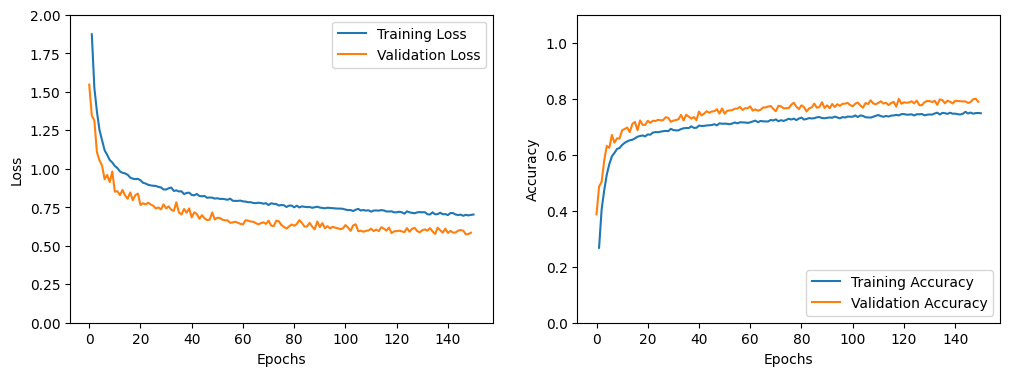

In [18]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

### Evaluation

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 149) - Validation Loss: 0.576, Validation Accuracy: 0.796


In [20]:

start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.796
Test Time: 14.82 seconds ---> 0.25 minutes


### Class Accuracy

In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
           
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []
y_score = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       450
           1       0.94      0.95      0.94       450
           2       0.76      0.60      0.67       450
           3       0.61      0.41      0.49       375
           4       0.92      0.93      0.92       375
           5       0.68      0.86      0.76       300
           6       0.62      0.77      0.69       375
           7       0.90      0.97      0.94       450
           8       0.62      0.72      0.67       375
           9       0.97      0.95      0.96       450

    accuracy                           0.80      4050
   macro avg       0.79      0.80      0.79      4050
weighted avg       0.80      0.80      0.80      4050

Class 0 Accuracy: 0.793
Class 1 Accuracy: 0.947
Class 2 Accuracy: 0.584
Class 3 Accuracy: 0.416
Class 4 Accuracy: 0.920
Class 5 Accuracy: 0.870
Class 6 Accuracy: 0.776
Class 7 Accuracy: 0.971
Class 8 Accuracy: 0.707
Cl

### Confusion Matrix

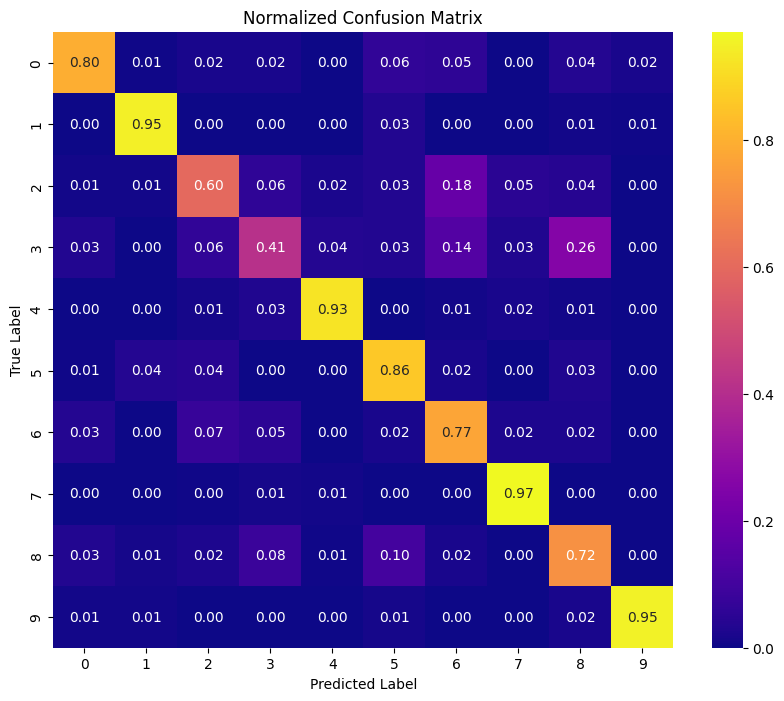

In [24]:
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='plasma', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()


### AUC ROC Curve

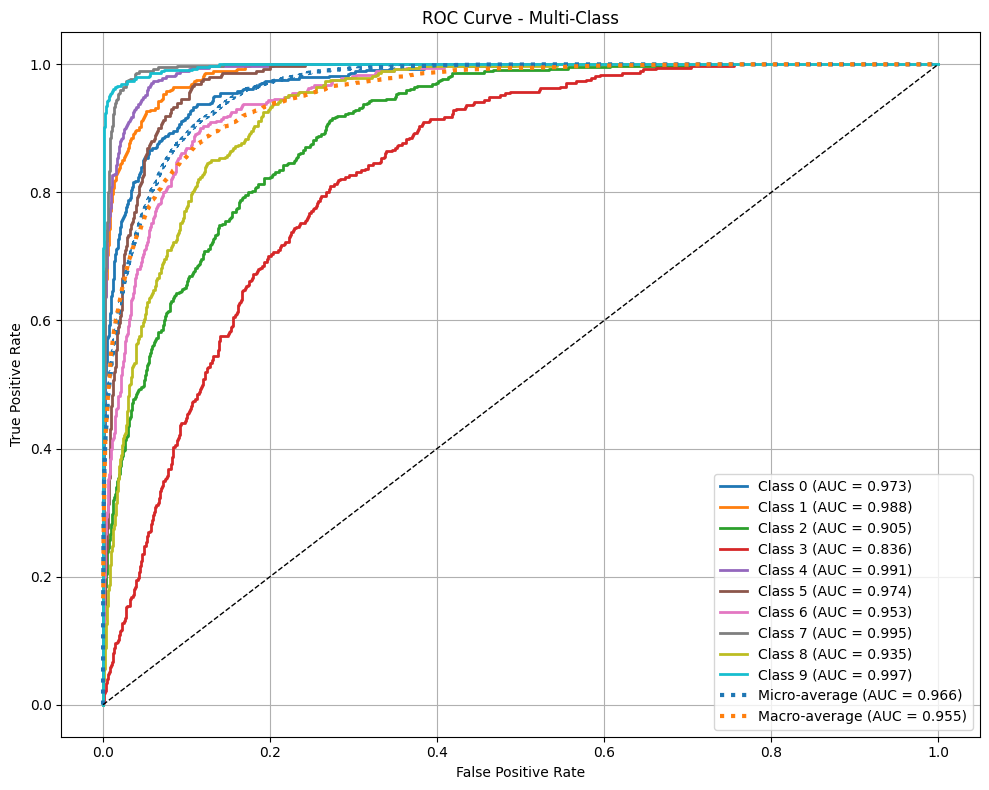

In [28]:
# Binarize the true labels
classes_list = sorted(list(set(y_true)))
y_true_bin = label_binarize(y_true, classes=classes_list)

fpr, tpr, roc_auc = {}, {}, {}

# Per-class ROC & AUC
for i in range(total_class):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(total_class)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(total_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= total_class
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ----- Plot ROC curves -----
plt.figure(figsize=(10, 8))

# Per-class curves
for i in range(total_class):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f"Class {classes_list[i]} (AUC = {roc_auc[i]:.3f})")

# Micro and Macro curves
plt.plot(fpr["micro"], tpr["micro"], linestyle=':', linewidth=3,
         label=f"Micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle=':', linewidth=3,
         label=f"Macro-average (AUC = {roc_auc['macro']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-Class")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()